In [49]:
import pandas as pd  
import numpy as np
from skimpy import skim

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_classif

from xgboost import XGBClassifier

from multiprocessing import pool

from keras.models import Sequential
from keras.layers import Dense, Dropout, Normalization
from keras.losses import BinaryCrossentropy

In [8]:
master_df = pd.read_csv('classification_task.csv')
master_df = master_df[master_df['distance'].isna() == False]

In [9]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9857 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   shipment_issue      9857 non-null   int64  
 1   carrier             9857 non-null   object 
 2   shipping_method     9857 non-null   object 
 3   distance            9857 non-null   float64
 4   package_type        9857 non-null   object 
 5   location            9857 non-null   object 
 6   customer_tier       9857 non-null   object 
 7   weather_conditions  9857 non-null   object 
 8   holiday_period      9857 non-null   object 
 9   pop_density         9857 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 847.1+ KB


In [10]:
skim(master_df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 10000  │ │ string      │ 8     │                                                          │
│ │ Number of columns │ 10     │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name        ┃ NA   ┃ NA %   ┃ mean     ┃ sd       ┃ p0      ┃ p25  ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ shipment_issue     │    0 │      0 │   0.0929 │   0.2903 │       0 │    0 │     0 │     0 │     1 │ ▇    ▁ │  │
│ │ distance           │  143 │   1.43 │     1002 │    575.9 │   10.03 │  503 │  1003 │  1500 │  2000 │ ▇▇▇▇▇▇ │  │
│ └────────────────────┴──────┴────────┴──────────┴──────────┴─────────┴──────┴───────┴───────┴───────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                        ┃ NA     ┃ NA %      ┃ words per row             ┃ total words          ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ carrier                            │      0 │         0 │                         1 │                10000 │  │
│ │ shipping_method                    │      0 │         0 │                         1 │                10000 │  │
│ │ package_type                       │      0 │         0 │                         1 │                10000 │  │
│ │ location                           │      0 │         0 │                         1 │                10000 │  │
│ │ customer_tier                      │      0 │         0 │                         1 │                10000 │  │
│ │ weather_conditions                 │      0 │         0 │                         1 │                10000 │  │
│ │ holiday_period                     │      0 │         0 │                         1 │                10000 │  │
│ │ pop_density                        │      0 │         0 │                         1 │                10000 │  │
│ └────────────────────────────────────┴────────┴───────────┴───────────────────────────┴──────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

<Axes: xlabel='distance', ylabel='Count'>

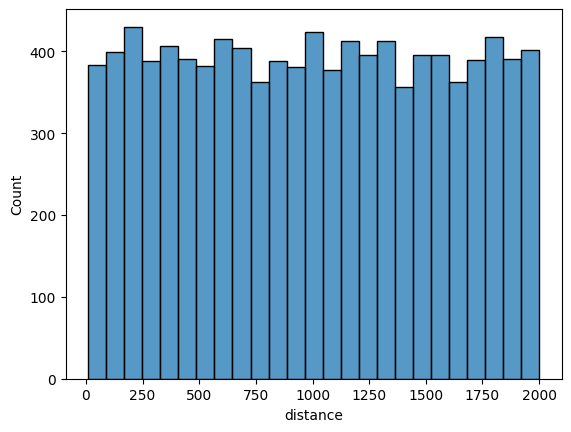

In [14]:
sns.histplot(data=master_df, x='distance',bins=25)

In [15]:
master_df.columns

Index(['shipment_issue', 'carrier', 'shipping_method', 'distance',
       'package_type', 'location', 'customer_tier', 'weather_conditions',
       'holiday_period', 'pop_density'],
      dtype='object')

In [18]:
for col in master_df.columns:
    print(col)
    print(pd.value_counts(master_df[col]))
    print()
    

shipment_issue
shipment_issue
0    9071
1     929
Name: count, dtype: int64

carrier
carrier
Carrier_A    6121
Carrier_B    2387
Carrier_C    1492
Name: count, dtype: int64

shipping_method
shipping_method
Standard     6955
Expedited    3045
Name: count, dtype: int64

distance
distance
300.268335     1
11.621088      1
363.360787     1
734.324458     1
366.162803     1
              ..
1264.935574    1
1113.317340    1
1260.097578    1
1256.912213    1
1814.614166    1
Name: count, Length: 9857, dtype: int64

package_type
package_type
Medium    5023
Large     4977
Name: count, dtype: int64

location
location
Suburban    3391
Urban       3325
Rural       3284
Name: count, dtype: int64

customer_tier
customer_tier
Basic      7998
Premium    2002
Name: count, dtype: int64

weather_conditions
weather_conditions
Clear    7530
Rain     1474
Snow      996
Name: count, dtype: int64

holiday_period
holiday_period
Holiday_Period_No     9051
Holiday_Period_Yes     949
Name: count, dtype: int64

p

/tmp/ipykernel_940254/4058676440.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(master_df[col]))
/tmp/ipykernel_940254/4058676440.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(master_df[col]))
/tmp/ipykernel_940254/4058676440.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(master_df[col]))
/tmp/ipykernel_940254/4058676440.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(master_df[col]))
/tmp/ipykernel_940254/4058676440.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).

In [19]:
master_df

,shipment_issue,carrier,shipping_method,distance,package_type,location,customer_tier,weather_conditions,holiday_period,pop_density
0,0,Carrier_C,Expedited,300.268335,Medium,Suburban,Basic,Clear,Holiday_Period_No,Medium
1,0,Carrier_C,Standard,1430.088462,Medium,Rural,Basic,Clear,Holiday_Period_No,Low
2,0,Carrier_A,Expedited,1007.817178,Medium,Suburban,Basic,Clear,Holiday_Period_No,Medium
3,0,Carrier_A,Standard,143.138222,Large,Rural,Basic,Clear,Holiday_Period_No,Low
4,0,Carrier_B,Expedited,40.525166,Medium,Suburban,Basic,Clear,Holiday_Period_No,Medium
...,...,...,...,...,...,...,...,...,...,...
9995,0,Carrier_B,Standard,640.979312,Medium,Suburban,Basic,Snow,Holiday_Period_Yes,Medium
9996,0,Carrier_A,Expedited,1992.135769,Large,Suburban,Basic,Clear,Holiday_Period_Yes,Medium
9997,0,Carrier_A,Expedited,30.531525,Medium,Urban,Basic,Clear,Holiday_Period_No,High
9998,0,Carrier_C,Standard,1621.989508,Large,Suburban,Basic,Clear,Holiday_Period_No,Medium


In [20]:
master_df.columns

Index(['shipment_issue', 'carrier', 'shipping_method', 'distance',
       'package_type', 'location', 'customer_tier', 'weather_conditions',
       'holiday_period', 'pop_density'],
      dtype='object')

<Axes: xlabel='carrier', ylabel='count'>

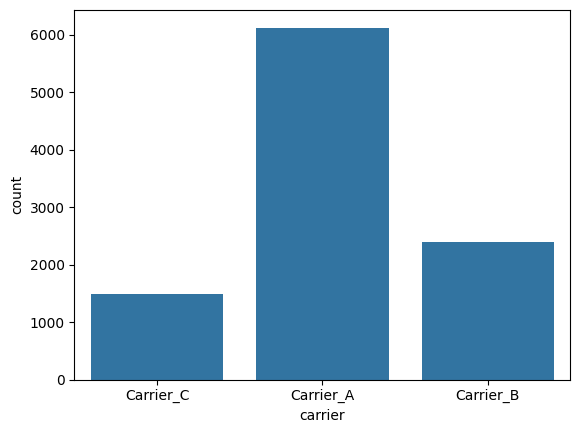

In [21]:
sns.countplot(data=master_df, x='carrier')

<Axes: xlabel='package_type', ylabel='count'>

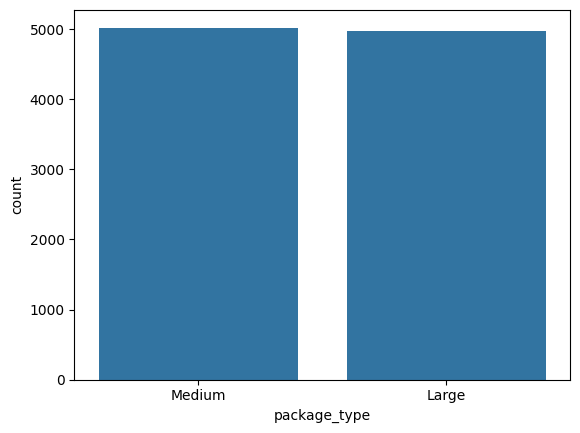

In [22]:
sns.countplot(data=master_df, x='package_type')

<Axes: xlabel='location', ylabel='count'>

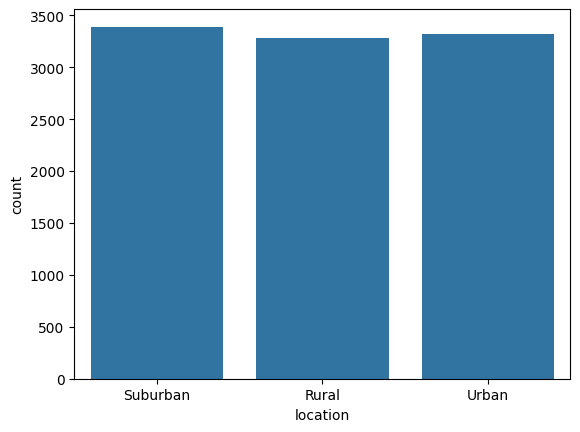

In [23]:
sns.countplot(data=master_df, x='location')

In [74]:
pd.read_csv('classification_task.csv')

,shipment_issue,carrier,shipping_method,distance,package_type,location,customer_tier,weather_conditions,holiday_period,pop_density
0,0,Carrier_C,Expedited,300.268335,Medium,Suburban,Basic,Clear,Holiday_Period_No,Medium
1,0,Carrier_C,Standard,1430.088462,Medium,Rural,Basic,Clear,Holiday_Period_No,Low
2,0,Carrier_A,Expedited,1007.817178,Medium,Suburban,Basic,Clear,Holiday_Period_No,Medium
3,0,Carrier_A,Standard,143.138222,Large,Rural,Basic,Clear,Holiday_Period_No,Low
4,0,Carrier_B,Expedited,40.525166,Medium,Suburban,Basic,Clear,Holiday_Period_No,Medium
...,...,...,...,...,...,...,...,...,...,...
9995,0,Carrier_B,Standard,640.979312,Medium,Suburban,Basic,Snow,Holiday_Period_Yes,Medium
9996,0,Carrier_A,Expedited,1992.135769,Large,Suburban,Basic,Clear,Holiday_Period_Yes,Medium
9997,0,Carrier_A,Expedited,30.531525,Medium,Urban,Basic,Clear,Holiday_Period_No,High
9998,0,Carrier_C,Standard,1621.989508,Large,Suburban,Basic,Clear,Holiday_Period_No,Medium


<Axes: xlabel='weather_conditions', ylabel='count'>

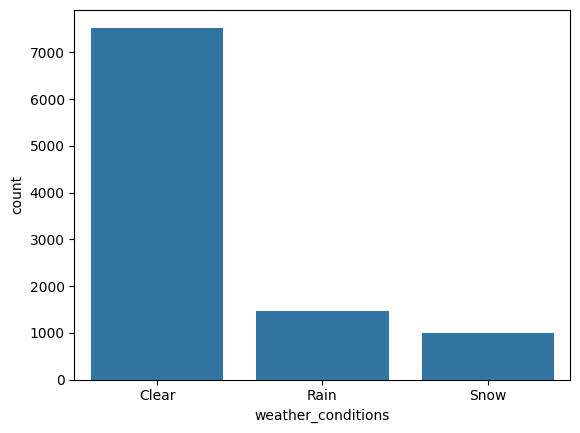

In [24]:
sns.countplot(data=master_df, x='weather_conditions')

In [46]:
master_df.columns

Index(['shipment_issue', 'carrier', 'shipping_method', 'distance',
       'package_type', 'location', 'customer_tier', 'weather_conditions',
       'holiday_period', 'pop_density'],
      dtype='object')

In [50]:
master_df['customer_tier'].unique()

array(['Basic', 'Premium'], dtype=object)

In [51]:
# variables to OHE: carrier, package_type

In [10]:
drop_enc = OneHotEncoder(drop='first').fit(pd.DataFrame(master_df['carrier']))
new_values = drop_enc.transform(pd.DataFrame(master_df['carrier'])).toarray()

In [11]:
df = master_df.drop('carrier',axis=1)

In [12]:
df[drop_enc.get_feature_names_out()[0]] = new_values[:,0]
df[drop_enc.get_feature_names_out()[1]] = new_values[:,1]

In [13]:
def encode_size(x):
    
    size_dict = {
        'Medium':0,
        'Large':1
    }
    
    return size_dict[x]

In [82]:
df['shipping_method'].unique()

array(['Expedited', 'Standard'], dtype=object)

In [14]:
def encode_shipping(x):
    
    size_dict = {
        'Expedited':0,
        'Standard':1
    }
    
    return size_dict[x]

In [87]:
df['holiday_period']

0        Holiday_Period_No
1        Holiday_Period_No
2        Holiday_Period_No
3        Holiday_Period_No
4        Holiday_Period_No
               ...        
9995    Holiday_Period_Yes
9996    Holiday_Period_Yes
9997     Holiday_Period_No
9998     Holiday_Period_No
9999     Holiday_Period_No
Name: holiday_period, Length: 10000, dtype: object

In [15]:
def encode_holiday(x):
    
    size_dict = {
        'Holiday_Period_No':0,
        'Holiday_Period_Yes':1
    }
    
    return size_dict[x]

In [16]:
def encode_weather(x):
    
    size_dict = {
        'Clear':0,
        'Rain':1,
        'Snow':2
    }
    
    return size_dict[x]

In [17]:
def encode_population(x):
    
    size_dict = {
        'Low':0,
        'Medium':1,
        'High':2
    }
    
    return size_dict[x]

In [99]:
df['pop_density'].unique()

array(['Medium', 'Low', 'High'], dtype=object)

In [18]:
def encode_customer(x):
    
    size_dict = {
        'Basic':1,
        'Premium':0
    }
    
    return size_dict[x]

In [19]:
def encode_town(x):
    
    size_dict = {
        'Rural':0,
        'Suburban':1,
        'Urban':2
    }
    
    return size_dict[x]

In [20]:
df['package_type'] = df['package_type'].apply(encode_size)

In [21]:
df['shipping_method'] = df['shipping_method'].apply(encode_shipping)

In [22]:
df['holiday_period'] = df['holiday_period'].apply(encode_holiday)

In [23]:
df['customer_tier'] = df['customer_tier'].apply(encode_customer)

In [24]:
df['weather_conditions'] = df['weather_conditions'].apply(encode_weather)

In [25]:
df['pop_density'] = df['pop_density'].apply(encode_population)

In [26]:
df['location'] = df['location'].apply(encode_town)

In [111]:
df['location'].unique()

array(['Suburban', 'Rural', 'Urban'], dtype=object)

In [27]:
df = df[df['distance'].isna()==False]

In [28]:
df_train_valid, df_test = train_test_split(df, test_size=.15, stratify=df['shipment_issue'])
X_train, X_test, y_train, y_test = train_test_split(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'], test_size=0.2, random_state=42)
k = 5
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'], test_size=0.2, random_state=42)
k = 5
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [56]:
selected_features = selector.get_support(indices=True)

In [57]:
X_train.columns[selected_features]

Index(['location', 'weather_conditions', 'pop_density', 'carrier_Carrier_B',
       'carrier_Carrier_C'],
      dtype='object')

In [53]:
print("Selected features in X_train:", X_train[:, selected_features])

InvalidIndexError: (slice(None, None, None), array([3, 5, 7, 8, 9]))

In [36]:
def run_classifier(df_train_valid, model=LogisticRegression(), feature_subset=[]):
    under_sampler = RandomUnderSampler(sampling_strategy=.5, random_state=42)
    X_new, y_new = under_sampler.fit_resample(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'])
    df_train_valid = pd.concat([X_new, y_new],axis=1)
    
    if len(feature_subset) == 0:
        k_strat = StratifiedKFold(n_splits=5, shuffle=False)
        folds = k_strat.split(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'])
        acc = []
        baseline_acc = []
        
        for train, test in folds:
            
            X_train, X_test = df_train_valid.drop('shipment_issue',axis=1).iloc[train], df_train_valid.drop('shipment_issue',axis=1).iloc[test]
            y_train, y_test = df_train_valid['shipment_issue'].values[train], df_train_valid['shipment_issue'].values[test]
            model.fit(StandardScaler().fit_transform(X_train), y_train)
            y_preds_LR = model.predict(StandardScaler().fit_transform(X_test))
            y_preds_baseline = np.tile(0, len(y_test))
            
            accuracy_score_baseline = roc_auc_score(y_test, y_preds_baseline)
            accuracy_score_LR = roc_auc_score(y_test, y_preds_LR)
            acc.append(accuracy_score_LR)
            baseline_acc.append(accuracy_score_baseline)

        print(np.average(acc), np.average(baseline_acc))
    
    else:
        feature_subset.append('shipment_issue')
        df_train_valid = df_train_valid[feature_subset]
        k_strat = StratifiedKFold(n_splits=5, shuffle=False)
        folds = k_strat.split(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'])
        acc = []
        baseline_acc = []

        for train, test in folds:
            
            X_train, X_test = df_train_valid.drop('shipment_issue',axis=1).iloc[train], df_train_valid.drop('shipment_issue',axis=1).iloc[test]
            y_train, y_test = df_train_valid['shipment_issue'].values[train], df_train_valid['shipment_issue'].values[test]
            model.fit(StandardScaler().fit_transform(X_train), y_train)
            y_preds_LR = model.predict(StandardScaler().fit_transform(X_test))
            y_preds_baseline = np.tile(0, len(y_test))
            
            accuracy_score_baseline = roc_auc_score(y_test, y_preds_baseline)
            accuracy_score_LR = roc_auc_score(y_test, y_preds_LR)
            acc.append(accuracy_score_LR)
            baseline_acc.append(accuracy_score_baseline)

        print(np.average(acc), np.average(baseline_acc))

In [44]:
import optuna

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [67]:
len(df_train_valid.columns)

11

In [70]:
def run_RandomForest(df_train_valid):
    
    X_train, X_test, y_train, y_test = train_test_split(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'], test_size=0.2, random_state=42)
    k = 5
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    selected_features = selector.get_support(indices=True)
    
    under_sampler = RandomUnderSampler(sampling_strategy=.5, random_state=42)
    X_new, y_new = under_sampler.fit_resample(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'])
    df_train_valid = pd.concat([X_new, y_new],axis=1)
    

    k_strat = StratifiedKFold(n_splits=5, shuffle=False)
    folds = k_strat.split(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'])
    acc = []
    baseline_acc = []
    
    for train, test in folds:
        
        X_train, X_test = df_train_valid.drop('shipment_issue',axis=1).iloc[train], df_train_valid.drop('shipment_issue',axis=1).iloc[test]
        y_train, y_test = df_train_valid['shipment_issue'].values[train], df_train_valid['shipment_issue'].values[test]
        X_train = X_train[X_train.columns[selected_features]]
        X_test = X_test[X_test.columns[selected_features]]
        
        def objective(trial):
            
            n_estimators = trial.suggest_int("n_estimators", 10, 200)
            max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
            min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
            min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

            # Create and train the model
            model = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42,
            )
            model.fit(X_train, y_train)
            
            model.fit(StandardScaler().fit_transform(X_train), y_train)
            y_preds = model.predict(StandardScaler().fit_transform(X_test))
            
            return roc_auc_score(y_test, y_preds)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=30)
        best_params = study.best_params
        
        model = RandomForestClassifier(**best_params)
        model.fit(StandardScaler().fit_transform(X_train), y_train)
        y_preds = model.predict(StandardScaler().fit_transform(X_test))
        y_preds_baseline = np.tile(0, len(y_test))
        
        accuracy_score_baseline = roc_auc_score(y_test, y_preds_baseline)
        accuracy_score_LR = roc_auc_score(y_test, y_preds)
        acc.append(accuracy_score_LR)
        baseline_acc.append(accuracy_score_baseline)

    print(np.average(acc), np.average(baseline_acc))

In [71]:
def run_RandomForest(df_train_valid):
    
    under_sampler = RandomUnderSampler(sampling_strategy=.5, random_state=42)
    X_new, y_new = under_sampler.fit_resample(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'])
    df_train_valid = pd.concat([X_new, y_new],axis=1)
    

    k_strat = StratifiedKFold(n_splits=5, shuffle=False)
    folds = k_strat.split(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'])
    acc = []
    baseline_acc = []
    
    for train, test in folds:
        
        X_train, X_test = df_train_valid.drop('shipment_issue',axis=1).iloc[train], df_train_valid.drop('shipment_issue',axis=1).iloc[test]
        y_train, y_test = df_train_valid['shipment_issue'].values[train], df_train_valid['shipment_issue'].values[test]
        
        def objective(trial):
            
            n_estimators = trial.suggest_int("n_estimators", 10, 200)
            max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
            min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
            min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

            # Create and train the model
            model = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42,
            )
            model.fit(X_train, y_train)
            
            model.fit(StandardScaler().fit_transform(X_train), y_train)
            y_preds = model.predict(StandardScaler().fit_transform(X_test))
            
            return roc_auc_score(y_test, y_preds)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=30)
        best_params = study.best_params
        
        model = RandomForestClassifier(**best_params)
        model.fit(StandardScaler().fit_transform(X_train), y_train)
        y_preds = model.predict(StandardScaler().fit_transform(X_test))
        y_preds_baseline = np.tile(0, len(y_test))
        
        accuracy_score_baseline = roc_auc_score(y_test, y_preds_baseline)
        accuracy_score_LR = roc_auc_score(y_test, y_preds)
        acc.append(accuracy_score_LR)
        baseline_acc.append(accuracy_score_baseline)

    print(np.average(acc), np.average(baseline_acc))

In [62]:
def run_XGBoost(df_train_valid):
    under_sampler = RandomUnderSampler(sampling_strategy=.5, random_state=42)
    X_new, y_new = under_sampler.fit_resample(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'])
    df_train_valid = pd.concat([X_new, y_new],axis=1)
    

    k_strat = StratifiedKFold(n_splits=5, shuffle=False)
    folds = k_strat.split(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'])
    acc = []
    baseline_acc = []
    
    for train, test in folds:
        
        X_train, X_test = df_train_valid.drop('shipment_issue',axis=1).iloc[train], df_train_valid.drop('shipment_issue',axis=1).iloc[test]
        y_train, y_test = df_train_valid['shipment_issue'].values[train], df_train_valid['shipment_issue'].values[test]
        X_train = X_train[X_train.columns[selected_features]]
        X_test = X_test[X_test.columns[selected_features]]
        
        def objective(trial):
            
            param = {
                'objective': 'binary:logistic',
                'tree_method': 'auto',
                'eval_metric': 'mlogloss',
                'booster': 'gbtree',
                'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
                'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
                'subsample': trial.suggest_float('subsample', 0.4, 1.0),
                'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 20),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'gamma': trial.suggest_float('gamma', 0, 5)
            }

            # Create and train the model
            model = XGBClassifier(**param)
            model.fit(StandardScaler().fit_transform(X_train), y_train)
            y_preds = model.predict(StandardScaler().fit_transform(X_test))
            accuracy_score = roc_auc_score(y_test, y_preds)
            
            return accuracy_score
    
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=30)
        best_params = study.best_params
        
        model = XGBClassifier(**best_params)
        model.fit(StandardScaler().fit_transform(X_train), y_train)
        y_preds = model.predict(StandardScaler().fit_transform(X_test))
        y_preds_baseline = np.tile(0, len(y_test))
        
        accuracy_score_baseline = roc_auc_score(y_test, y_preds_baseline)
        accuracy_score_LR = roc_auc_score(y_test, y_preds)
        acc.append(accuracy_score_LR)
        baseline_acc.append(accuracy_score_baseline)

    print(np.average(acc), np.average(baseline_acc))

In [72]:
run_RandomForest(df_train_valid)

[I 2024-10-28 16:04:11,144] A new study created in memory with name: no-name-6387c5e0-8260-4a19-8c5b-76f3d07c31e4
[I 2024-10-28 16:04:11,420] Trial 0 finished with value: 0.5064516129032258 and parameters: {'n_estimators': 79, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.5064516129032258.
[I 2024-10-28 16:04:12,110] Trial 1 finished with value: 0.6229942100909843 and parameters: {'n_estimators': 135, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.6229942100909843.
[I 2024-10-28 16:04:12,624] Trial 2 finished with value: 0.5129032258064516 and parameters: {'n_estimators': 155, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.6229942100909843.
[I 2024-10-28 16:04:13,138] Trial 3 finished with value: 0.614836641852771 and parameters: {'n_estimators': 125, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0

KeyboardInterrupt: 

In [242]:
k_strat = StratifiedKFold(n_splits=5, shuffle=False)
folds = k_strat.split(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'])
acc = []

for train, test in folds:
    
    X_train, X_test = df_train_valid.drop('shipment_issue',axis=1).iloc[train], df_train_valid.drop('shipment_issue',axis=1).iloc[test]
    y_train, y_test = df_train_valid['shipment_issue'].values[train], df_train_valid['shipment_issue'].values[test]
    model = LogisticRegression()
    model.fit(StandardScaler().fit_transform(X_train), y_train)
    y_preds_LR = model.predict(StandardScaler().fit_transform(X_test))

    accuracy_score_LR = roc_auc_score(y_test, y_preds_LR)
    acc.append(accuracy_score_LR)

print(np.average(acc))

0.5


In [243]:
k_strat = StratifiedKFold(n_splits=5, shuffle=False,)
folds = k_strat.split(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'])
acc = []

for train, test in folds:
    
    X_train, X_test = df_train_valid.drop('shipment_issue',axis=1).iloc[train], df_train_valid.drop('shipment_issue',axis=1).iloc[test]
    y_train, y_test = df_train_valid['shipment_issue'].values[train], df_train_valid['shipment_issue'].values[test]
    model = XGBClassifier()
    model.fit(StandardScaler().fit_transform(X_train), y_train)
    y_preds_LR = model.predict(StandardScaler().fit_transform(X_test))

    accuracy_score_LR = roc_auc_score(y_test, y_preds_LR)
    acc.append(accuracy_score_LR)

print(np.average(acc))

0.510714270166732


0.9074626865671642

In [187]:
len(x[0][1])

1676

In [257]:
X_train, X_test, y_train, y_test = train_test_split(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'], test_size=.25, stratify=df_train_valid['shipment_issue'])

In [258]:
baseline_accuracy = roc_auc_score(y_test, np.tile(1,len(y_test)))

In [259]:
baseline_accuracy

0.5

In [260]:
model = LogisticRegression()
model.fit(StandardScaler().fit_transform(X_train), y_train)
y_preds_LR = model.predict(StandardScaler().fit_transform(X_test))

accuracy_score_LR = roc_auc_score(y_test, y_preds_LR)
print(accuracy_score_LR)

0.5


In [262]:
model = RandomForestClassifier()
model.fit(StandardScaler().fit_transform(X_train), y_train)
y_preds_RF = model.predict(StandardScaler().fit_transform(X_test))

accuracy_score_RF = roc_auc_score(y_test, y_preds_RF)
print(accuracy_score_RF)

0.5347638326585695


In [190]:
model = XGBClassifier()
model.fit(StandardScaler().fit_transform(X_train), y_train)
y_preds_XGB = model.predict(StandardScaler().fit_transform(X_test))

accuracy_score_XGB = accuracy_score(y_test, y_preds_XGB)

In [263]:
model = Sequential()

model.add(Dense(units=32, input_dim=X_train.shape[1], activation='tanh'))
model.add(Dropout(.5))
model.add(Normalization())
model.add(Dense(units=16, activation='tanh'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(X_train, y_train)

y_preds_NN = model.predict(X_test)
y_preds_NN = (y_preds_NN >= .5).astype(int)

roc_auc_score(y_test, y_preds_NN)

/home/bstager/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7623
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


0.5

In [ ]:
model = Seq

In [192]:
roc_auc_score(y_test, np.tile(0, len(y_test)))

0.5

In [191]:
roc_auc_score(y_test, y_preds_RF)

0.5295006747638327